In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using KernelDensity
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP

In [45]:
include("../model-41/likelihood.jl")
include("../model-41/utill_model.jl")
include("../utill.jl")

plot_projections (generic function with 1 method)

In [3]:
function hist_2d(smpls, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [4]:
β1 = 0.015
β2 = 0.0077 # (0.8/30/sqrt(12))
β3 = 0.0058 # (0.8/40/sqrt(12))

# flat prior for the pixel size
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.50 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    )

labels = [L"\sigma_x", L"\sigma_y", L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", L"\sigma'_x", L"\sigma'_y", L"\alpha", L"s", L"s",
    L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_y", L"\mu_y", L"\mu_y", L"\mu_y", 
    "ped", "lf", "a", 
    "res x", "res x", "res x", "res y", "res y", "res y", "res x", "res y", 
    "ps x", "ps x", "ps x", "ps y", "ps y", "ps y", "ps x", "ps y", 
    "la", "la", "la"
    ];

In [5]:
FPATH = "../../data/sampling_results/Benchmark-5/"

"../../data/sampling_results/Benchmark-5/"

In [6]:
readdir(FPATH)

27-element Array{String,1}:
 "hc-1.hdf5"
 "hc-113.hdf5"
 "hc-188.hdf5"
 "hc-2.hdf5"
 "hc-26.hdf5"
 "hc-281.hdf5"
 "hc-3.hdf5"
 "hc-311.hdf5"
 "hc-322.hdf5"
 "hc-357.hdf5"
 "hc-4.hdf5"
 "hc-435.hdf5"
 "lc-1.hdf5"
 ⋮
 "lc-169.hdf5"
 "lc-2.hdf5"
 "lc-225.hdf5"
 "lc-262.hdf5"
 "lc-299.hdf5"
 "lc-3.hdf5"
 "lc-343.hdf5"
 "lc-355.hdf5"
 "lc-369.hdf5"
 "lc-4.hdf5"
 "lc-48.hdf5"
 "lc-5.hdf5"

In [7]:
filename = readdir(FPATH)[4]
smpl_tmp = bat_read(FPATH*filename)
samples = varshape(prior).(smpl_tmp);

In [8]:
filename

# Example HC "hc-2.hdf5"
# Example LC "lc-169.hdf5"

"hc-2.hdf5"

In [9]:
smpl_vect = mode(samples)

ShapedAsNT((tr_size = [0.11981972652758177, 0.09508268999730499], tr_size_2 = [0.13855187855536683, 0.1398729539822064], ang_spr = [5.330137541842466, 6.729064329781098], ang_spr_2 = [1.380619756369, 3.52321780367145], mixt_pow = 0.6653570591720431, waist = [3.150542303580399], waist_2 = [2.924574018111657], algmx = [36.92308744817537, 37.42281813600263, 20.386802444050492, 33.894444122011436], algmy = [31.690717161982274, 32.21526838495275, 21.216828464049733, 35.22623552803752], cam4_ped = 27.684348858141504, cam4_light_fluct = 1.3773055875248577, cam4_light_amp = 8.844283725066225, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 5.991794997159232, cam4_resy = 2.0655668581066564, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.487431035523848, 11.389608582466336, 2.5432967448816832], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [ ]:
# hist_tmp = hist_2d(samples, 1,2, nbins=40,)

# valss = sort([hist_tmp.weights...])
# valss_rc = valss ./ sum(valss)
# intt = [0.0001, 0.001, 0.006, 0.9999, 1]
# cvals = unique([valss[argmin(abs.(valss_rc .- i))] for i in intt])

# fig, ax= plt.subplots(1,1, figsize=(6,6))

# ax.contourf(
#     midpoints(hist_tmp.edges[1]), 
#     midpoints(hist_tmp.edges[2]), 
#     hist_tmp.weights', 
#     levels= 4, #cvals, 
#     cmap="Blues", alpha=0.6, antialiased=true) 

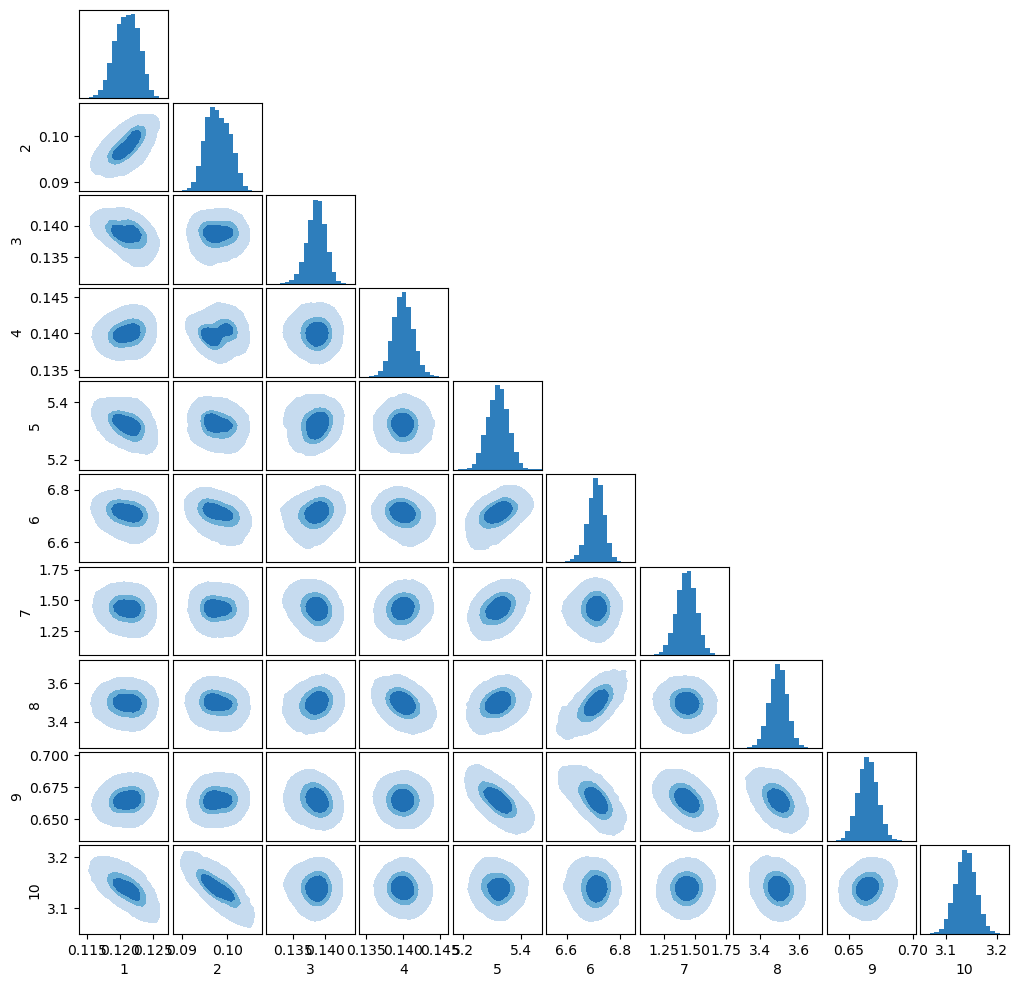

In [10]:
dims = [1,2,3,4,5,6,7,8,9,10]
names = [1,2,3,4,5,6,7,8,9,10]
levels = [0.0001, 0.65, 0.9, 0.95,  1,]
# levels = [0.001, 0.65, 0.95, 1,]
figsize = (12,12)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

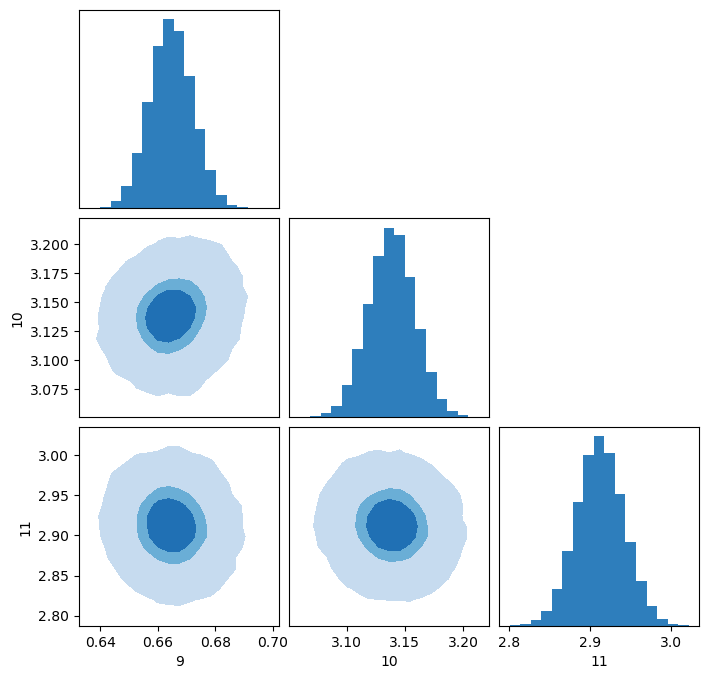

In [11]:
dims = [9,10,11,]
names = [9,10,11,]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

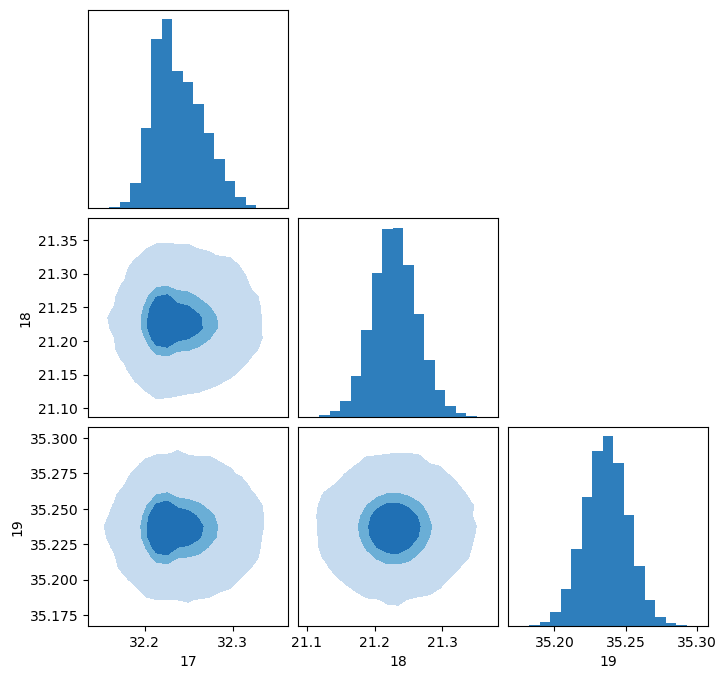

In [12]:
dims = [17,18,19]
names = [17,18,19]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

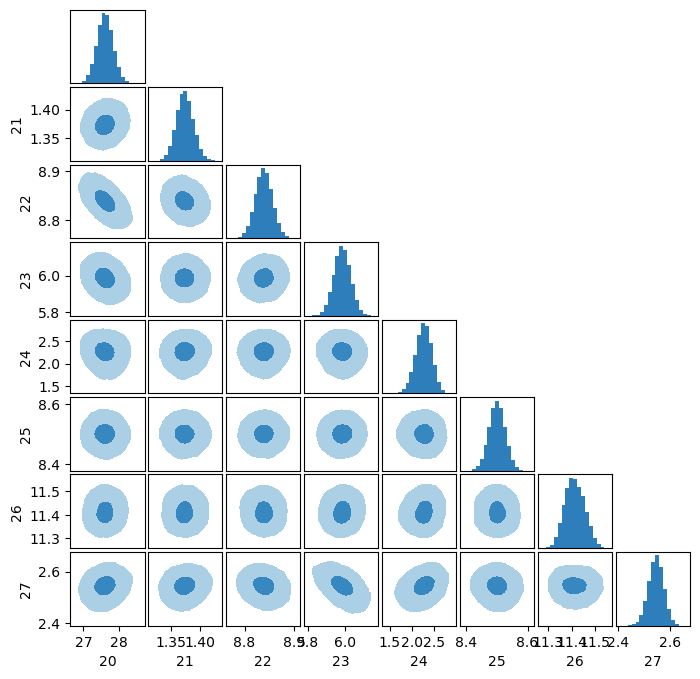

In [13]:
dims = [20,21,22,23,24,25,26,27]
names = [20,21,22,23,24,25,26,27]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [14]:
dims = [28,29,30,31,32,33,34,35]
names = [28,29,30,31,32,33,34,35]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 27×893414 Array{Float64,2} at index [28, 1:893414]

In [15]:
dims = [36,37,38]
names = [36,37,38]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 27×893414 Array{Float64,2} at index [36, 1:893414]

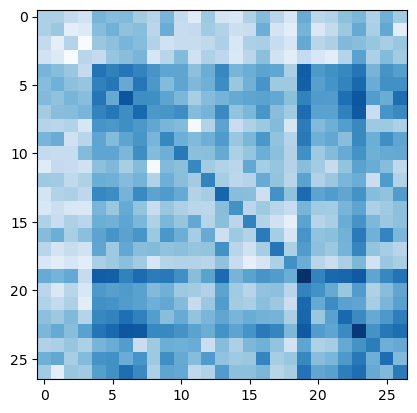

PyObject <matplotlib.image.AxesImage object at 0x7fcb95cc6400>

In [16]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

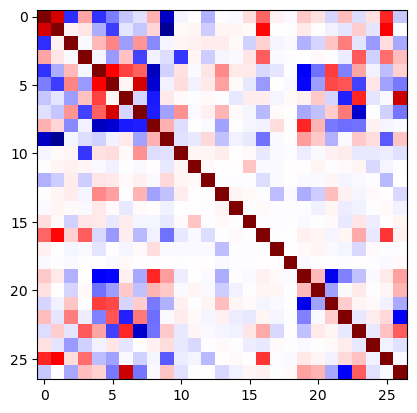

PyObject <matplotlib.image.AxesImage object at 0x7fcb8a4181c0>

In [17]:
dt_reg = flatview(unshaped.(samples.v)) ./ std(flatview(unshaped.(samples.v)), dims=2)
dt_reg = dt_reg .- mean(dt_reg, dims=2)
dt_reg = cov(dt_reg')
max = maximum(abs.(dt_reg))

plt.imshow(dt_reg, cmap="seismic", vmin=-max, vmax=max)

In [35]:
if filename[1:2] == "hc"
    
    conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
    
    images = load("../../data/experiment/dataset_2/m2/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
end

(cam_1 = [11.0 0.0 … 0.0 695.0; 25.0 0.0 … 0.0 0.0; … ; 0.0 14.0 … 0.0 0.0; 145.0 8.0 … 29.0 132.0], cam_2 = [0.0 0.0 … 0.0 0.0; 217.0 0.0 … 0.0 0.0; … ; 0.0 127.0 … 0.0 0.0; 0.0 0.0 … 115.0 0.0], cam_3 = [454.0 86.0 … 0.0 0.0; 190.0 129.0 … 0.0 0.0; … ; 9.0 91.0 … 7.0 14.0; 20.0 4.0 … 10.0 10.0], cam_4 = [23.0 18.0 … 24.0 19.0; 18.0 20.0 … 27.0 14.0; … ; 30.0 15.0 … 24.0 15.0; 36.0 19.0 … 25.0 14.0], population = 26.462099075317383)

In [36]:
if filename[1:2] == "lc"
    @show "true"
    conv_mat = load("../../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    )
    
    images = load("../../data/experiment/dataset_2/m1/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );

end

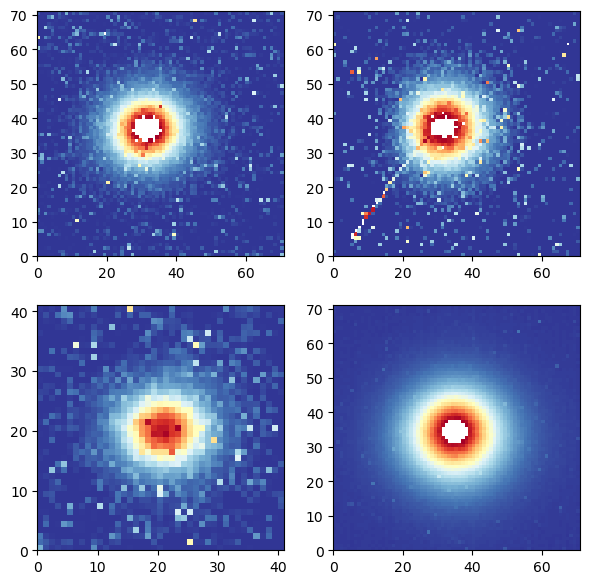

PyObject <matplotlib.collections.QuadMesh object at 0x7fcba4dce880>

In [37]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

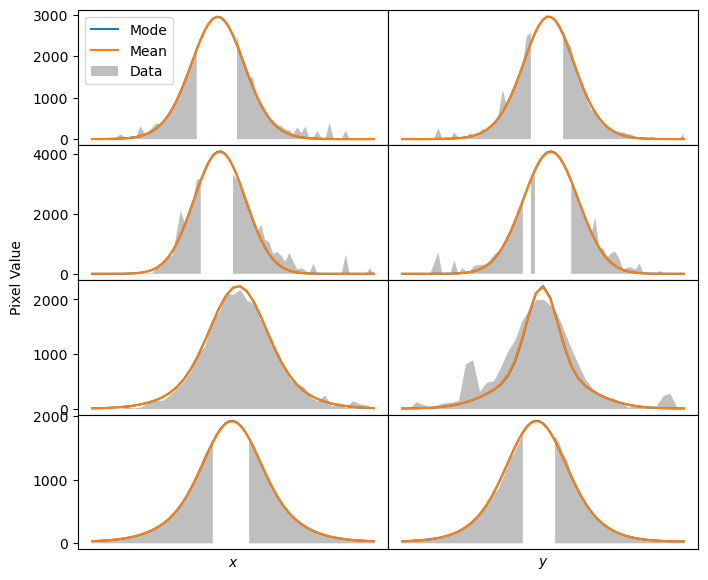

PyObject Text(0.04, 0.5, 'Pixel Value')

In [46]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

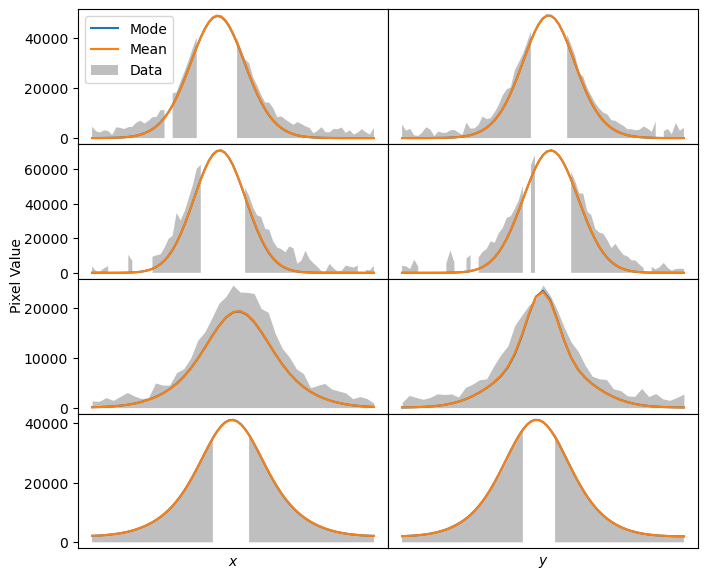

PyObject Text(0.04, 0.5, 'Pixel Value')

In [47]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

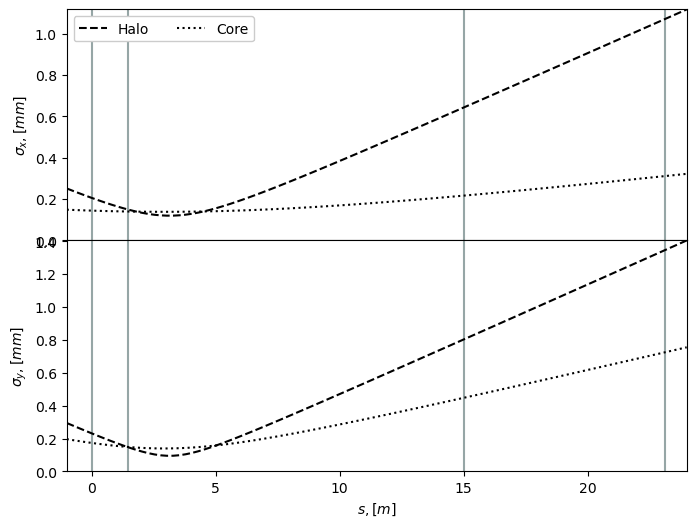

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [48]:
params_array = [mode(samples)[1],]
colors_array = ["gray",]
labels_array = ["Truth", ]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

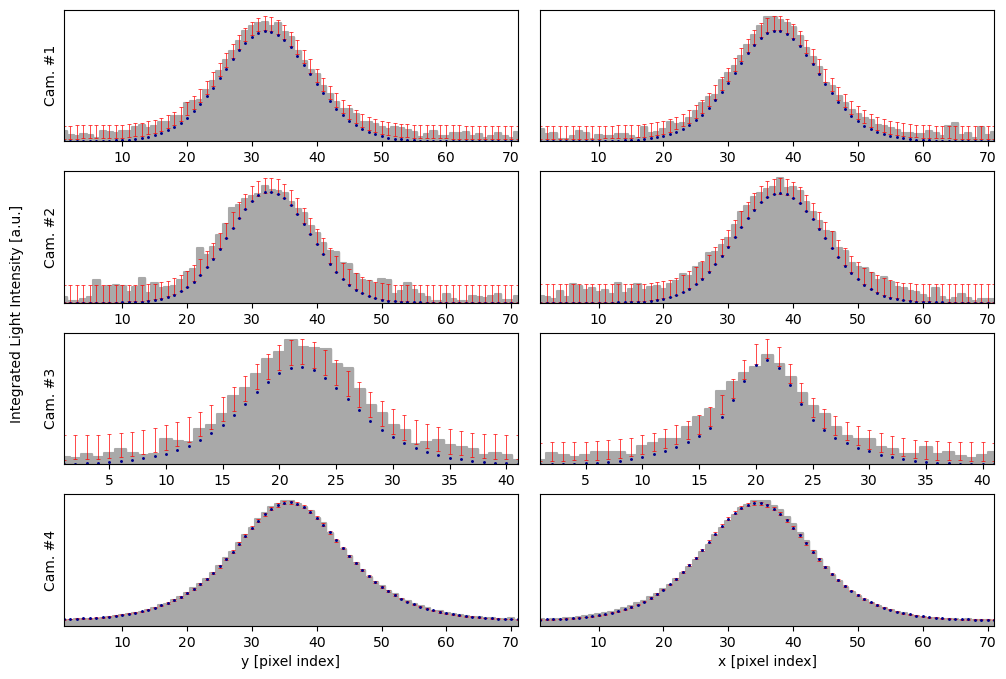

PyObject Text(0.08, 0.5, 'Integrated Light Intensity [a.u.]')

In [49]:
plot_projections(conv_matrices, event_nt, event_nt, params_array[1], isnontr = true)

In [50]:
function plot_sign_comp(params, cam_ind, npix)

    σ_x = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    σ_x_2 = sqrt.(params.tr_size_2[1]^2 + 10^-4*params.ang_spr_2[1]^2*(params.waist_2[1] - params.s_cam[cam_ind])^2) 
        
    σ_y = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    σ_y_2 = sqrt.(params.tr_size_2[2]^2 + 10^-4*params.ang_spr_2[2]^2*(params.waist_2[1] - params.s_cam[cam_ind])^2) 
    
    if cam_ind < 4
        x_bins = range(0, length = npix+1, step = params.psx[cam_ind]*10^-3)
        y_bins = range(0, length = npix+1, step = params.psy[cam_ind]*10^-3)
    else
        x_bins = range(0, length = npix+1, step = params.cam4_psx*10^-3)
        y_bins = range(0, length = npix+1, step = params.cam4_psy*10^-3)
    end
    
    mue_x = maximum(x_bins) / 2
    mue_y = maximum(y_bins) / 2
    
    vals_x_1 = diff(cdf.(Normal(mue_x, σ_x), x_bins))
    vals_x_2 = diff(cdf.(Normal(mue_x, σ_x_2), x_bins))
    
    vals_y_1 = diff(cdf.(Normal(mue_y, σ_y), y_bins))
    vals_y_2 = diff(cdf.(Normal(mue_y, σ_y_2), y_bins))

    
    fig, ax = plt.subplots(2,1, figsize=(7,5), )
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    
    
    ax[1].plot(x_bins[1:end-1], params.mixt_pow .* vals_x_1, color="k", ls="--", label="Halo")
    ax[1].plot(x_bins[1:end-1], (1-params.mixt_pow).*vals_x_2, color="k", ls=":", label="Core")
    ax[1].plot(x_bins[1:end-1], (1-params.mixt_pow).*vals_x_2 .+ params.mixt_pow .* vals_x_1, color="red", label="Sum")
    ax[1].legend(loc="upper right")
    
    
    ax[2].plot(y_bins[1:end-1], params.mixt_pow .* vals_y_1, color="k", ls="--")
    ax[2].plot(y_bins[1:end-1], (1-params.mixt_pow).*vals_y_2, color="k", ls=":")
    ax[2].plot(y_bins[1:end-1], (1-params.mixt_pow).*vals_y_2 .+ params.mixt_pow .* vals_y_1, color="red")
    
    ax[1].set_xlabel(L"\mathrm{x \; (mm)}")
    ax[2].set_xlabel(L"\mathrm{y \; (mm)}")
end

plot_sign_comp (generic function with 1 method)

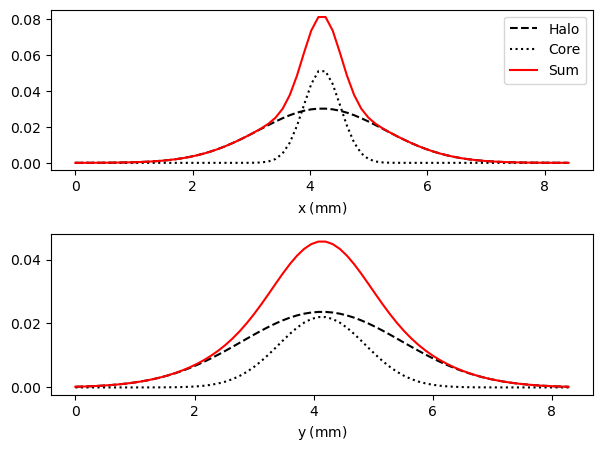

PyObject Text(0.5, 28.0, '$\\mathrm{y \\; (mm)}$')

In [51]:
plot_sign_comp(params_array[1], 4, 70)